# Проект Рекоммендательной Системы
**Мачин Иван**

## Постановка задачи
Задача: Ранжирование товаров  
Специфика задачи:
- Бинарность (2 класса: 0 - юзер не приобретал товар, 1 - приобретал)
- Implicit feedback

Таргет: Вероятность принадлежности item_id к классу 1 для выбранного user_id  
Вывод модели: Список Top-N товаров

Метрики:
MAP, MAR, F1-score (фокус на MAR)  
*NDCG в данном случае не подходит*

## EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/wb_school_task_1.csv')

In [3]:
data.head()

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000


In [4]:
print(f"Количество покупок (записей в датасете): {data.shape[0]}")
print(f"Количество уникальных пользователей (user_id): {data.nunique().user_id}")
print(f"Количество уникальных товаров (item_id): {data.nunique().item_id}")
print(f"Density: {len(data) / (len(set(data.user_id)) * len(set(data.item_id)))}")

Количество покупок (записей в датасете): 21265784
Количество уникальных пользователей (user_id): 1057265
Количество уникальных товаров (item_id): 6562
Density: 0.0030652176447060514


In [5]:
f"Временной промежуток: {data.order_ts.min(), data.order_ts.max()}"

"Временной промежуток: ('2023-01-01 00:00:05.000000', '2023-03-31 23:59:59.947831')"

In [6]:
print("Пропущенные значения: ")
data.isnull().sum()

Пропущенные значения: 


user_id     0
item_id     0
order_ts    0
dtype: int64

In [7]:
f"Число дублей: {data.duplicated().sum()}"

'Число дублей: 2006497'

In [8]:
# Создаем новый дф для трансформаций
df = data.copy()
# Убираем дублирующиеся строки
df = data.drop_duplicates()

In [9]:
df = df.sort_values(['user_id', 'item_id', 'order_ts'])

In [10]:
f"Число дублирующихся пар (юзер, товар): {df.duplicated(['user_id', 'item_id']).sum()}"

'Число дублирующихся пар (юзер, товар): 5188430'

In [11]:
df.drop_duplicates(['user_id', 'item_id'], keep='first', inplace=True)

In [12]:
print(f"Среднее число покупок на юзера: {df.groupby('user_id').agg('count')['item_id'].mean()}")
print(f"Ср. кв. отклонение покупок на юзера: {df.groupby('user_id').agg('count')['item_id'].std()}")
print(f"Среднее число уникальных юзеров на товар: {df.groupby('item_id').agg('count')['user_id'].mean()}")
print(f"Ср. кв. отклонение уникальных юзеров на товар: {df.groupby('item_id').agg('count')['user_id'].std()}")

Среднее число покупок на юзера: 13.308732436995456
Ср. кв. отклонение покупок на юзера: 15.291677155922832
Среднее число уникальных юзеров на товар: 2144.2939652544956
Ср. кв. отклонение уникальных юзеров на товар: 8693.205766060928


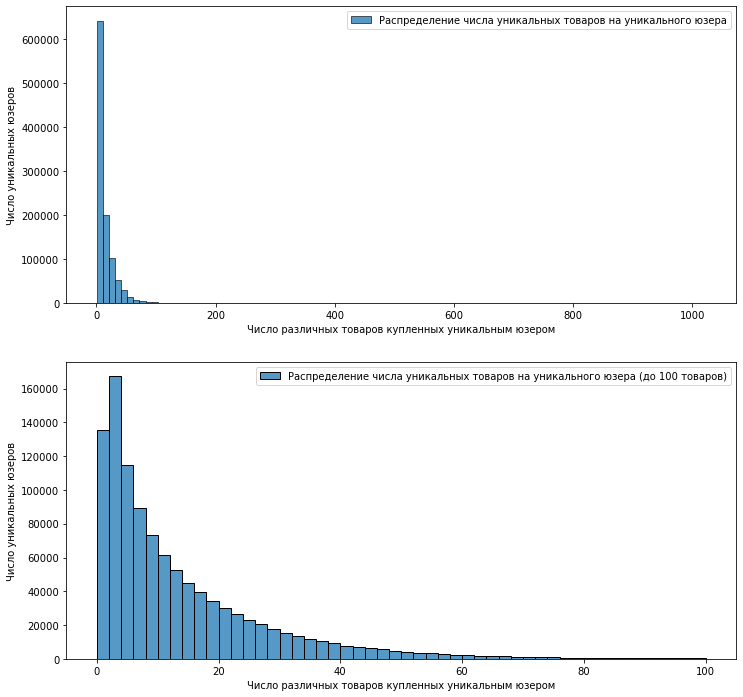

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(df.groupby('user_id').count()['item_id'], bins=100, ax=ax[0],
            label='Распределение числа уникальных товаров на уникального юзера')
ax[0].set_xlabel('Число различных товаров купленных уникальным юзером')
ax[0].set_ylabel('Число уникальных юзеров')
ax[0].legend()
sns.histplot(df.groupby('user_id').count()['item_id'], bins=50, binrange=[0, 100], ax=ax[1],
            label='Распределение числа уникальных товаров на уникального юзера (до 100 товаров)')
ax[1].set_xlabel('Число различных товаров купленных уникальным юзером')
ax[1].set_ylabel('Число уникальных юзеров')
ax[1].legend()
plt.show()

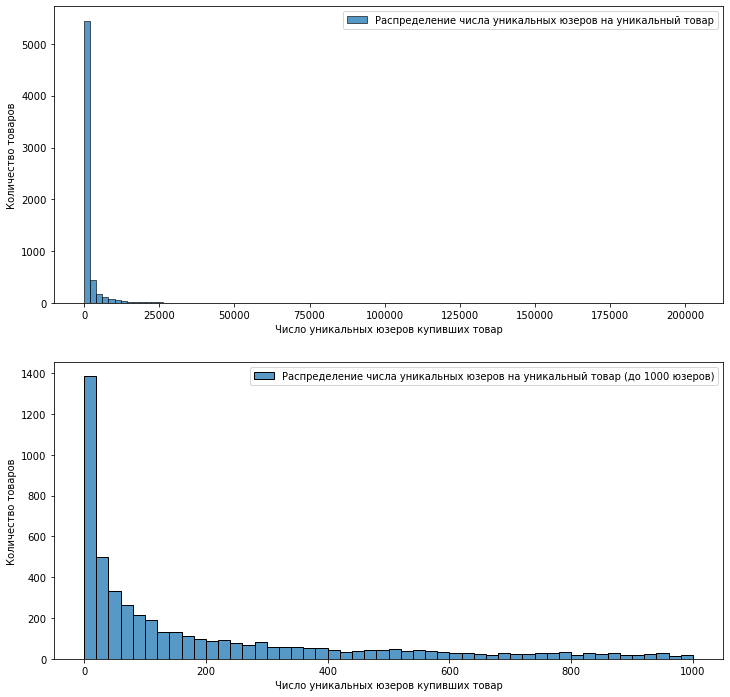

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.histplot(df.groupby('item_id').count()['user_id'], bins=100, ax=ax[0],
            label='Распределение числа уникальных юзеров на уникальный товар')
ax[0].set_xlabel('Число уникальных юзеров купивших товар')
ax[0].set_ylabel('Количество товаров')
ax[0].legend()
sns.histplot(df.groupby('item_id').count()['user_id'], bins=50, binrange=[0, 1000], ax=ax[1],
            label='Распределение числа уникальных юзеров на уникальный товар (до 1000 юзеров)')
ax[1].set_xlabel('Число уникальных юзеров купивших товар')
ax[1].set_ylabel('Количество товаров')
ax[1].legend()
plt.show()

In [15]:
# Характеристики распределения числа уникальных товаров сгруппированных по юзеру
df.groupby('user_id').count()['item_id'].describe()

count    1.057265e+06
mean     1.330873e+01
std      1.529168e+01
min      1.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.800000e+01
max      1.022000e+03
Name: item_id, dtype: float64

In [16]:
# Характеристики распределения числа уникальных юзеров сгруппированных по приобретенному товару
df.groupby('item_id').count()['user_id'].describe()

count      6562.000000
mean       2144.293965
std        8693.205766
min           1.000000
25%          29.000000
50%         185.000000
75%         988.750000
max      202508.000000
Name: user_id, dtype: float64

In [17]:
# конвертируем строковый timestamp в datetime формат
df['order_ts'] = pd.to_datetime(df['order_ts'])

<AxesSubplot:xlabel='order_ts'>

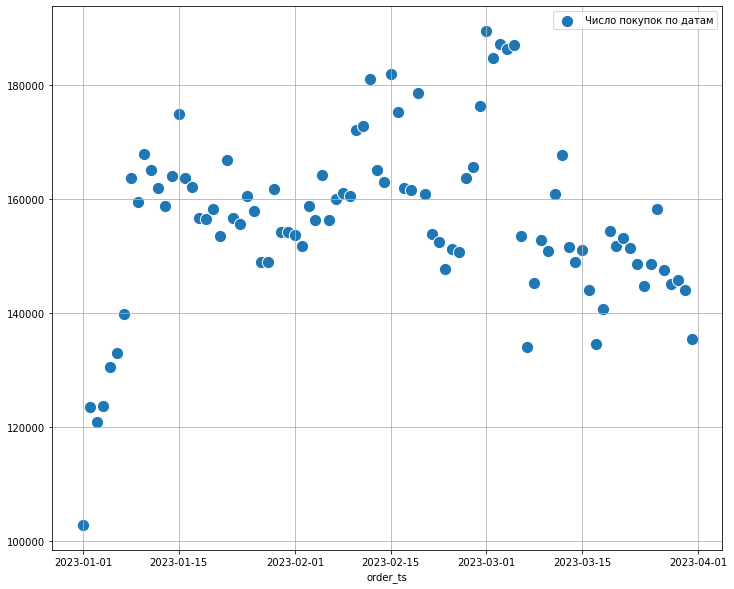

In [20]:
tmp = df.groupby([df['order_ts'].dt.date]).count()['item_id']

plt.figure(figsize=(12, 10))
plt.grid(True)
sns.scatterplot(data=tmp, x=tmp.index, y=tmp.values, s=150,
            label='Число покупок по датам')